# Check emission pairs to see which are missing in construction

In [270]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm, setup_ind_scm
from src.utils.sem_utils.emissions import get_emissions_input_output_pairs
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.emissions import fit_sem_emit_fncs, fit_sem_emit_fncs_v2
from src.utils.sem_utils.transitions import fit_sem_trans_fncs_v2
from numpy.random import seed


from src.utils.sem_utils.toy_sems import StationaryDependentSEM as StatSEM
from src.utils.sem_utils.toy_sems import StationaryIndependentSEM as StatIndSEM
from src.methods.bo import BO
seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


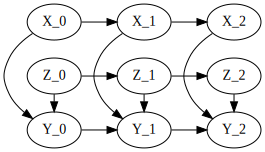

In [271]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_ind_scm(T)
# This is just a snapshot of the DAG at hand
dag_view

In [230]:
dag.add_edge("Z_0","X_0")
dag.add_edge("Z_1","X_1")
dag.add_edge("Z_2","X_2")

dag.remove_edge("X_0","Z_0")
dag.remove_edge("X_1","Z_1")
dag.remove_edge("X_2","Z_2")

In [253]:
dag.add_edge("X_0","Z_1")
dag.add_edge("Y_1","X_2")

0

In [272]:

# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_Obs = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_Obs

{'X': array([[ 1.76405235, -1.36389514,  2.34263312],
        [ 0.4105985 , -0.26655493,  1.72082844],
        [ 0.3130677 , -1.16716344, -1.38582637],
        [-0.18718385,  1.71996306, -0.25060429],
        [ 1.23029068, -0.02791083, -0.35941599]]),
 'Z': array([[ 2.2408932 , -0.37333521, -0.60394267],
        [ 0.76103773, -0.63936271,  1.08322594],
        [ 0.6536186 ,  0.2108176 , -0.95298262],
        [ 0.15494743,  0.22321509, -1.11100084],
        [-0.30230275, -0.74625021, -0.67376772]]),
 'Y': array([[ 7.10882731e-01, -2.03617251e-01, -3.32014694e-01],
        [-1.07756500e+00,  1.14084669e-03, -1.38551948e+00],
        [ 1.04683050e+00, -1.34749671e+00, -1.64937054e+00],
        [-2.72426851e+00, -3.72418733e+00, -3.73867129e+00],
        [-2.06046689e+00, -3.65357365e-01, -1.31548395e+00]])}

In [273]:
# Setup the input parameters to be used with the Bayesian optimization
BO_input_params = {
    "G": dag,
    "sem": StatIndSEM,
    "base_target_variable": "Y",
    "observation_samples": D_Obs,
    "intervention_domain": intervention_domain,
    "intervention_samples":None,   
    "number_of_trials": 10,
    "optimal_assigned_blankets": None,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": None
}
# Run Bayesian optimization
bo = BO(**BO_input_params)

In [274]:
bo.sem_emit_fncs

{0: {('Z_0',): <GPy.models.gp_regression.GPRegression at 0x7fbd7128dad0>,
  ('X_0',): <GPy.models.gp_regression.GPRegression at 0x7fbd71293c10>},
 1: {('Z_1',): <GPy.models.gp_regression.GPRegression at 0x7fbdc0934410>,
  ('X_1',): <GPy.models.gp_regression.GPRegression at 0x7fbd7128d510>},
 2: {('Z_2',): <GPy.models.gp_regression.GPRegression at 0x7fbd712b1710>,
  ('X_2',): <GPy.models.gp_regression.GPRegression at 0x7fbd712b1f50>}}

In [288]:
f = fit_sem_emit_fncs_v2(dag, D_Obs)

In [289]:
f

{0: {(None, 'X'): KernelDensity(),
  ('X',): <GPy.models.gp_regression.GPRegression at 0x7fbd712bf910>,
  ('Z',): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c99810>,
  (None, 'Z'): KernelDensity()},
 1: {('X',): <GPy.models.gp_regression.GPRegression at 0x7fbdd0cc04d0>,
  ('Z',): <GPy.models.gp_regression.GPRegression at 0x7fbdd0cc0150>},
 2: {('X',): <GPy.models.gp_regression.GPRegression at 0x7fbd9099a350>,
  ('Z',): <GPy.models.gp_regression.GPRegression at 0x7fbdb1632610>}}

In [112]:
from networkx.convert import to_dict_of_lists
import numpy as np
from src.utils.dag_utils.adjacency_matrix_utils import get_emit_and_trans_adjacency_mats

In [259]:
nodes = np.array(dag.nodes()).astype(str)
E_mat,T_mat, T = get_emit_and_trans_adjacency_mats(dag)
T_mat

array([[0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [262]:
fit_sem_trans_fncs_v2(dag,D_Obs)

{0: {},
 1: {('X',): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c719d0>,
  ('X', 'Z'): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c64110>,
  ('Y',): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c6a150>},
 2: {('X', 'Y'): <GPy.models.gp_regression.GPRegression at 0x7fbdd0c6a790>,
  ('Z',): <GPy.models.gp_regression.GPRegression at 0x7fbda0f9fa50>,
  ('Y',): <GPy.models.gp_regression.GPRegression at 0x7fbda0fa40d0>}}